Query NASA/Ads from python

https://github.com/adsabs/adsabs-dev-api/blob/master/README.md

In [1]:
from astroquery.ned import Ned
from astroquery.nasa_ads import ADS
ADS.TOKEN = open('ADS_DEV_KEY','r').read()
token = open('ADS_DEV_KEY','r').read()
import requests
import urllib
import json

In [3]:
result_table = Ned.get_table("NGC628", table='positions')

result_table

No.,RA,DEC,Frequency,Uncertainty Ellipse Semi-Major Axis,Uncertainty Ellipse Semi-Minor Axis,Uncertainty Ellipse PA,Refcode,Published Name,Published RA,Published Dec,Published RA Uncertainty,Published Dec Uncertainty,Published PA Uncertainty,Uncertainty Significance,Published Equinox,Published Epoch,NED Frequency,Published System Coordinate,Published Unit,Published Frame,Published Frequence Mode,Qualifiers
,,,,arcsec,arcsec,,,,,,,,,,,,Hz,,,,,
int32,object,object,object,float64,float64,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object
0,01h36m41.747s,+15d47m01.18s,,0.32,0.32,0,2010ApJS..189...37E,,,,,,,,,,--,,,,,
1,01h36m41.8000s,+15d47m01.000s,,--,--,,2014ApJS..212...18B,NGC 0628,013641.8,+154701.,,,,Uncertainty in arcseconds,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
2,01h36m41.8000s,+15d47m17.000s,,--,--,,2014MNRAS.439.2542G,NGC 0628,013641.8,+154717.,,,,Uncertainty in arcseconds,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
3,01h36m41.7600s,+15d47m00.000s,,--,--,,2014MNRAS.441.3570G,Messier 074,013641.76,+154700.0,,,,Uncertainty in arcseconds,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
4,01h36m41.7000s,+15d47m01.000s,,--,--,,2014PASJ...66...66T,MESSIER 074,013641.7,+154701.00,,,,Uncertainty in arcseconds,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
5,01h36m41.7600s,+15d47m00.384s,,--,--,,2011MNRAS.412.1419L,,013641.7600,+154700.384,,,,,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
6,01h36m41.8099s,+15d47m00.301s,,--,--,,2014MNRAS.442.3711G,,013641.81,+154700.3,,,,,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin
7,01h36m41.7000s,+15d47m01.000s,,--,--,,2014MNRAS.443..186H,,013641.7,+154701.,,,,,J2000.0,,--,Equatorial,Sexagesimal,,,Uncertain origin


In [5]:
def check_type(func):
    def inner(x,y):
        print()


@check_type
def add(x,y):
    return x+y


add(1,"2")


TypeError: 'NoneType' object is not callable

In [14]:
query = 'id:2019ApJ...887...80K'
query = urllib.parse.quote(query)

start=0
cache_rows=200
sort='pubdate+desc'

r = requests.get('https://api.adsabs.harvard.edu/v1/search/query?'
              f'q={query}&start={start}&rows={cache_rows}'
               f'&sort={sort}&fl=title,author,year,bibcode,pub',
               headers={'Authorization': f'Bearer {token}'})
    
resp = r.json()  


In [66]:
def get_bibtex(bibcodes):
    '''retrive the bibtex entry from ads
    
    '''
    
    if not isinstance(bibcodes,list):
        bibcodes = [bibcodes]
        
    bibcode = {"bibcode":bibcodes}
    r = requests.post("https://api.adsabs.harvard.edu/v1/export/bibtex", \
                     headers={"Authorization": "Bearer " + token, "Content-type": "application/json"}, \
                     data=json.dumps(bibcode))
    
    # in case of an error
    if not r.ok:
        if r.status_code == 401:
            raise ValueError('Unauthorized access to ADS. Check that the ADS token is valid.')
        try:
            reason = r.json()['error']
        except:
            reason = r.text
        raise ValueError(f'HTTP request failed ({r.status_code}): {reason}')
    
    return r.json()['export']

bib = get_bibtex(['2019ApJ...887...80K'])

In [53]:
r = requests.get("https://api.adsabs.harvard.edu/v1/search/query?q='references(id:2019ApJ...887...80K)'",\
                headers={'Authorization': 'Bearer ' + token})
# the requests package returns an object; to get just the JSON API response, you have to specify this
#print(r.json())
r.ok

False

https://github.com/andycasey/ads

In [54]:
import ads

In [55]:
ads.config.token = open('ADS_DEV_KEY','r').read()

In [70]:
bibcode = '2019ApJ...887...80K'

In [73]:
ads.SearchQuery?

In [74]:
list(ads.SearchQuery(bibcode=bibcode))

In [59]:
articles = [list(ads.SearchQuery(bibcode=bibcode))[0] for bibcode in bibcodes]

In [76]:
articles[0].reference

['1989ApJ...345..245C',
 '2003MNRAS.344.1000B',
 '2018A&A...616A...1G',
 '2009ARA&A..47..481A',
 '1998ARA&A..36..189K',
 '1981PASP...93....5B',
 '2004ApJ...613..898T',
 '2003MNRAS.346.1055K',
 '1999PASP..111...63F',
 '2004PASP..116..138C',
 '2004ARA&A..42..603K',
 '2015ApJ...798....7B',
 '2005ASPC..347...29T',
 '2008ApJ...681.1183K',
 '1994ApJ...420...87Z',
 '2012A&A...538A...8S',
 '2017MNRAS.466..798C',
 '2002ApJS..142...35K',
 '2006MNRAS.366.1151S',
 '2007ApJS..173..185G',
 '2018ApJ...860..172S',
 '2013A&A...559A.114M',
 '2014A&A...563A..49S',
 '2010SPIE.7735E..08B',
 '2018ApJ...863L..21K',
 '2018ApJ...861L..18U',
 '2015MNRAS.447.2857B',
 '2009RvMP...81..969H',
 '2017MNRAS.469..151B',
 '2001ApJS..132...37K',
 '1992MNRAS.259..121V',
 '2006A&A...459...85N',
 '2014ApJS..212...14L',
 '1997ApJ...489...63G',
 '2019MNRAS.484.5009E',
 '2018MNRAS.479.5235P',
 '2018MNRAS.479.1866K',
 '2016Ap&SS.361...61D',
 '2012MNRAS.424..157V',
 '2002ApJ...581.1019G',
 '1996AJ....111.2265F',
 '1999PASP..111.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

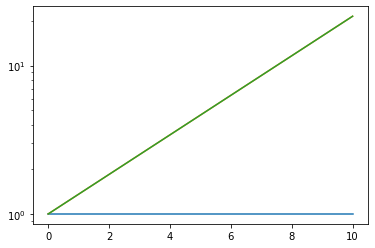

In [10]:
x = np.linspace(0,10)

y1 = (1-np.exp(3*(-4.47-x)))
y2 = np.exp(0.307*x)

y = y1*y2
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y)

plt.yscale('log')